In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

!pip install keras

In [2]:
#from _future_ import printfunction,unicode literals
import json
import requests
import xlrd
import openpyxl

In [3]:
RANDOM_SEED = 20090425

In [4]:
bj_senti = pd.read_csv("data/Key-Word Beijing Air PM2.5_senti.csv")

bj_senti

,time,positive,negative
0,2019/3/25,0.586957,0.413043
1,2019/3/25,0.141491,0.858509
2,2019/3/25,0.058706,0.941294
3,2019/3/25,0.073873,0.926127
4,2019/3/25,0.063313,0.936687
...,...,...,...
94,2019/3/11,0.920322,0.079678
95,2019/3/11,0.507447,0.492553
96,2019/3/11,0.407767,0.592233
97,2019/3/11,0.224801,0.775199


In [5]:
bj_senti_mean = bj_senti.mean()
bj_senti_mean

positive    0.364193
negative    0.635807
dtype: float64

In [6]:
bj_senti_var = bj_senti.var()
bj_senti_var

positive    0.075021
negative    0.075021
dtype: float64

In [7]:
bj_senti.positive

0     0.586957
1     0.141491
2     0.058706
3     0.073873
4     0.063313
        ...   
94    0.920322
95    0.507447
96    0.407767
97    0.224801
98    0.191724
Name: positive, Length: 99, dtype: float64

bj_senti = bj_senti.set_index('time')
bj_senti.head(50)

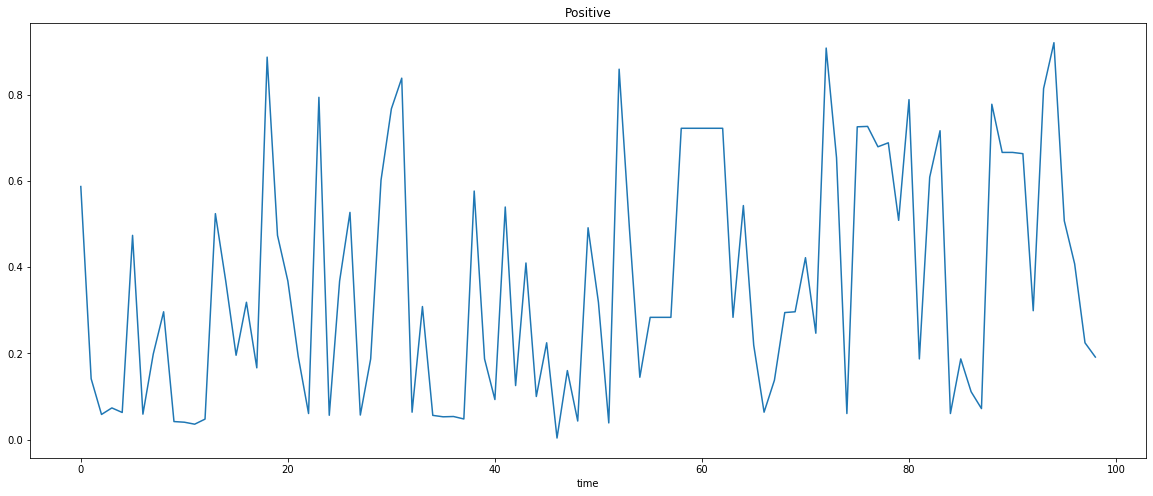

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(20,8))
plt.plot(bj_senti.positive)
plt.title('Positive')
# plt.ylabel('')
plt.xlabel('time')
plt.grid(False)
plt.show()

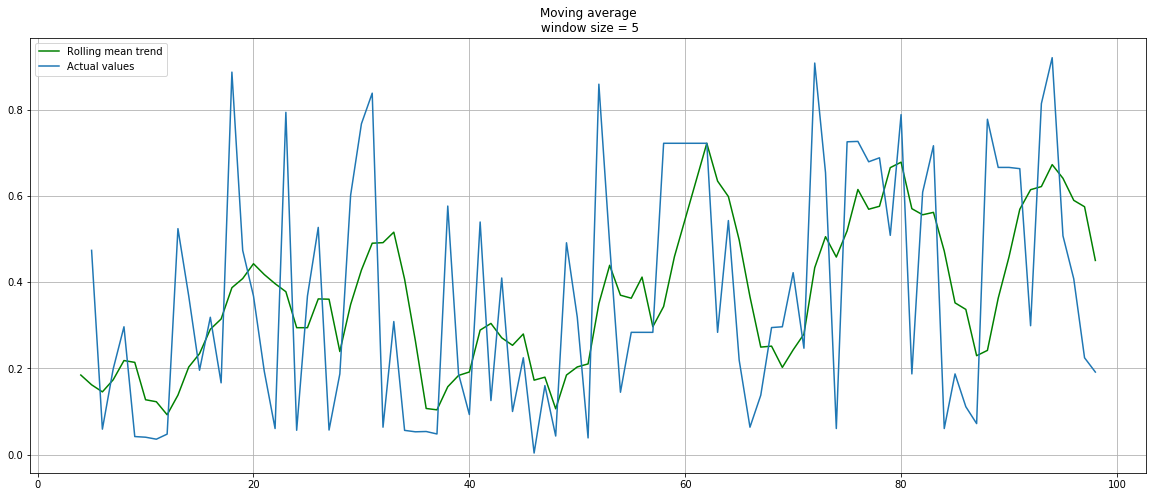

In [9]:
def plot_moving_average(series,window,plot_intervals=False, scale =1.96):
    rolling_mean = series.rolling(window=window).mean()
 
    plt.figure(figsize=(20,8))
    plt.title('Moving average\n window size = {}'.format(window))
    #smaller window, more details; more bigger window, you can see the plot
    plt.plot(rolling_mean, 'g', label='Rolling mean trend')
    #plt.plot(lwd = 1)

    #Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
        plt.plot(lower_bound, 'r--')

    plt.plot(series[window:], label='Actual values')
    plt.legend(loc='best')
    plt.grid(True)

#Smooth by the previous 5 days (by week)
plot_moving_average(bj_senti.positive, 5)

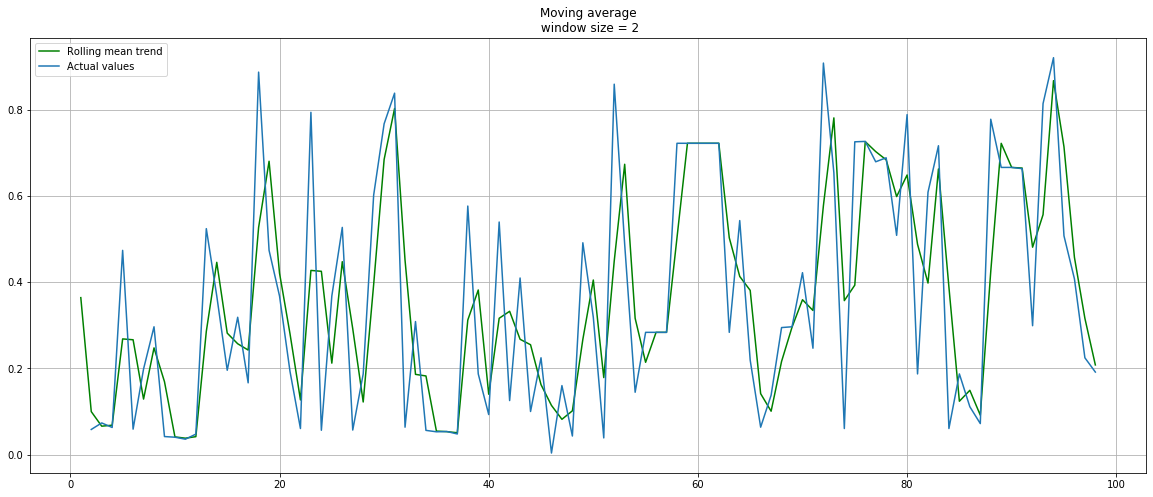

In [10]:
plot_moving_average(bj_senti.positive, 2)

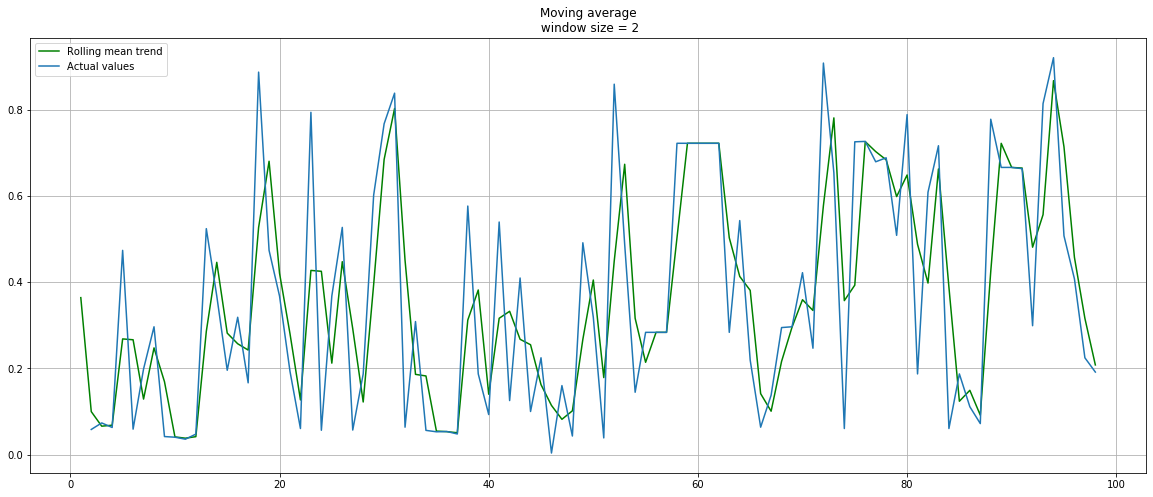

In [11]:
plot_moving_average(bj_senti.positive, 2, plot_intervals=False)

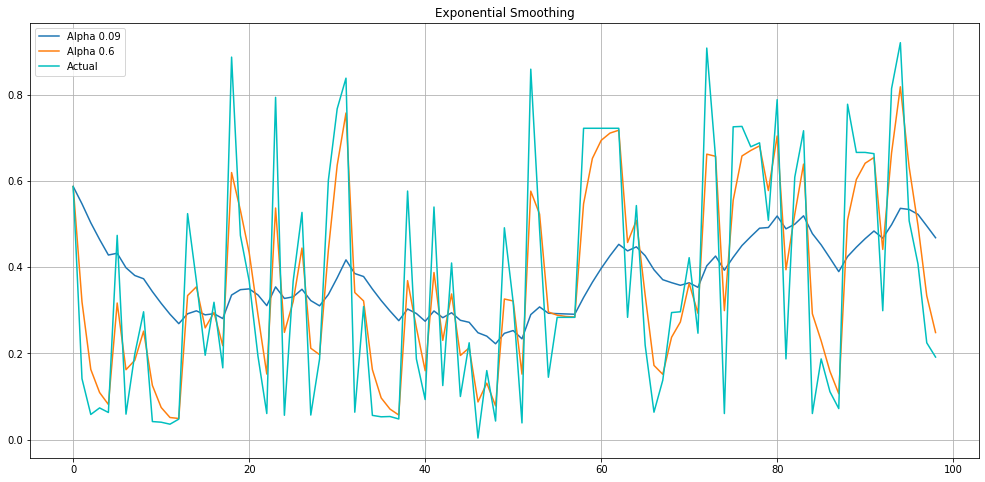

In [12]:
def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

def plot_exponential_smoothing(series, alphas):
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
    plt.plot(series.values, "c", label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    plt.grid(True);
        
plot_exponential_smoothing(bj_senti.positive, [0.09, 0.6])

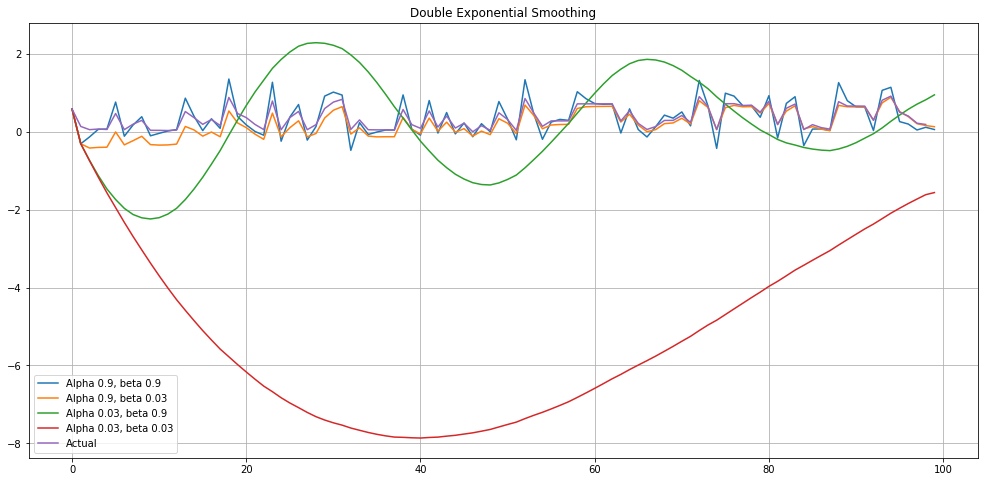

In [13]:
def double_exponential_smoothing(series, alpha, beta):
    result = [series[0]]
    
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        
        last_level, level = level, alpha * value + (1 - alpha) * (level + trend)
        trend = beta * (level - last_level) + (1 - beta) * trend
        result.append(level + trend)
    return result

def plot_double_exponential_smoothing(series, alphas, betas):
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        for beta in betas:
            plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
    plt.plot(series.values, label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Double Exponential Smoothing")
    plt.grid(True)

plot_double_exponential_smoothing(bj_senti.positive, alphas=[0.9, 0.03], betas=[0.9, 0.03])

In [14]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [15]:
# Some functions to help out with
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real Positive Value')
    plt.plot(predicted, color='blue',label='Predicted Positive Value')
    plt.title('Positive Value Prediction')
    plt.xlabel('Time')
    plt.ylabel('Positive Value')
    plt.legend()
    plt.show()

def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))


In [16]:
# First, we get the data
dataset = pd.read_csv('data/Key-Word Beijing Air PM2.5_senti.csv', index_col='time', parse_dates=['time'])
dataset = dataset.sort_values(by="time" , ascending=True)
dataset

,positive,negative
time,,
2019-03-10,0.191724,0.808276
2019-03-11,0.920322,0.079678
2019-03-11,0.224801,0.775199
2019-03-11,0.407767,0.592233
2019-03-11,0.507447,0.492553
...,...,...
2019-03-25,0.063313,0.936687
2019-03-25,0.073873,0.926127
2019-03-25,0.058706,0.941294


In [17]:
dataset["newindex"] = range(len(dataset))
dataset

,positive,negative,newindex
time,,,
2019-03-10,0.191724,0.808276,0
2019-03-11,0.920322,0.079678,1
2019-03-11,0.224801,0.775199,2
2019-03-11,0.407767,0.592233,3
2019-03-11,0.507447,0.492553,4
...,...,...,...
2019-03-25,0.063313,0.936687,94
2019-03-25,0.073873,0.926127,95
2019-03-25,0.058706,0.941294,96


In [18]:
dataset = dataset.set_index('newindex')
dataset

,positive,negative
newindex,,
0,0.191724,0.808276
1,0.920322,0.079678
2,0.224801,0.775199
3,0.407767,0.592233
4,0.507447,0.492553
...,...,...
94,0.063313,0.936687
95,0.073873,0.926127
96,0.058706,0.941294


In [19]:
# Checking for missing values
training_set = dataset[:80].iloc[:,:-1].values
test_set = dataset[80:].iloc[:,:-1].values
training_set.shape

(80, 1)

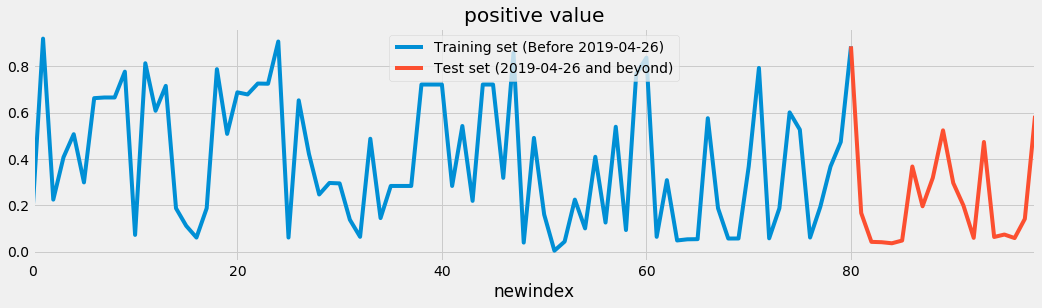

In [20]:
dataset["positive"][:81].plot(figsize=(16,4),legend=True)
dataset["positive"][80:].plot(figsize=(16,4),legend=True)
plt.legend(['Training set (Before 2019-04-26)','Test set (2019-04-26 and beyond)'])
plt.title('positive value')
plt.show()

In [21]:
# Since LSTMs store long term memory state, we create a data structure with 60 timesteps and 1 output
# So for each element of training set, we have 60 previous training set elements 
X_train = []
y_train = []
for i in range(3,80):
    X_train.append(training_set[i-3:i,0])
    y_train.append(training_set[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [22]:
# Reshaping X_train for efficient modelling
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

In [23]:
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))
# Second LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Third LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Fourth LSTM layer
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))
# The output layer
regressor.add(Dense(units=1))

# Compiling the RNN
regressor.compile(optimizer='rmsprop',loss='mean_squared_error')
# Fitting to the training set
regressor.fit(X_train,y_train,epochs=50,batch_size=32)

Epoch 1/50
77/77 [==============================] - 1s 19ms/step - loss: 0.2118
Epoch 2/50
77/77 [==============================] - 0s 257us/step - loss: 0.1560
Epoch 3/50
77/77 [==============================] - 0s 264us/step - loss: 0.0991
Epoch 4/50
77/77 [==============================] - 0s 328us/step - loss: 0.0774
Epoch 5/50
77/77 [==============================] - 0s 262us/step - loss: 0.0728
Epoch 6/50
77/77 [==============================] - 0s 285us/step - loss: 0.0734
Epoch 7/50
77/77 [==============================] - 0s 314us/step - loss: 0.0694
Epoch 8/50
77/77 [==============================] - 0s 356us/step - loss: 0.0725
Epoch 9/50
77/77 [==============================] - 0s 351us/step - loss: 0.0768
Epoch 10/50
77/77 [==============================] - 0s 326us/step - loss: 0.0735
Epoch 11/50
77/77 [==============================] - 0s 323us/step - loss: 0.0725
Epoch 12/50
77/77 [==============================] - 0s 422us/step - loss: 0.0732
Epoch 13/50
77/77 [=======

In [24]:
sc = MinMaxScaler(feature_range=(0,1))
training_set = sc.fit_transform(training_set)
training_set

array([[0.20480111],
       [1.        ],
       [0.24090095],
       [0.44059241],
       [0.54938417],
       [0.32203896],
       [0.71929892],
       [0.72244131],
       [0.72244131],
       [0.84429203],
       [0.0744789 ],
       [0.88385517],
       [0.65978097],
       [0.77730123],
       [0.20012338],
       [0.1171466 ],
       [0.06198893],
       [0.20012338],
       [0.85595343],
       [0.55061357],
       [0.7467586 ],
       [0.73670367],
       [0.78823488],
       [0.78723432],
       [0.98640831],
       [0.06198893],
       [0.7090448 ],
       [0.45619569],
       [0.26512568],
       [0.31936332],
       [0.31737241],
       [0.14619378],
       [0.06537394],
       [0.52787226],
       [0.15373434],
       [0.30528835],
       [0.30528835],
       [0.30528835],
       [0.78349575],
       [0.78349575],
       [0.78349575],
       [0.30528835],
       [0.5880109 ],
       [0.23493528],
       [0.78349575],
       [0.78349575],
       [0.34342617],
       [0.932

In [25]:
# Now to get the test set ready in a similar way as the training set.
dataset_total = pd.concat((dataset["positive"][:80],dataset["positive"][80:]),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set) - 3:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)
inputs

array([[0.20668248],
       [0.39716034],
       [0.51262365],
       [0.96347866],
       [0.17756078],
       [0.04167328],
       [0.04003209],
       [0.03501242],
       [0.04783497],
       [0.39716034],
       [0.20938288],
       [0.34342617],
       [0.56758246],
       [0.31936332],
       [0.2125721 ],
       [0.06041922],
       [0.51262365],
       [0.06465198],
       [0.0761776 ],
       [0.05962394],
       [0.14997658],
       [0.63616224]])

In [26]:
inputs[1:1,0]

array([], dtype=float64)

In [27]:
test_set.shape

(19, 1)

In [28]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(3,22):
    X_test.append(inputs[i-3:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_positive_value = regressor.predict(X_test)
predicted_positive_value = sc.inverse_transform(predicted_positive_value)

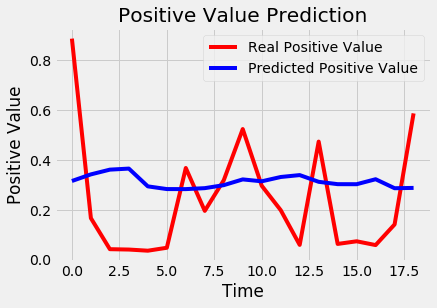

In [29]:
# Visualizing the results for LSTM
plot_predictions(test_set,predicted_positive_value)

In [30]:
# Evaluating our model
return_rmse(test_set,predicted_positive_value)

The root mean squared error is 0.24660568497555177.
